### These are the libraries we will need for the classification task

In [1]:
import os
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix


### Firstly we declare the path of the data for the classification task and also parameters for our CNN


In [2]:
DATA_DIR = r"C:\Unipi-CS\Πτυχιακή\datasets\raw\classification_task\train"  
BATCH_SIZE = 32
IMG_SIZE = 224
NUM_CLASSES = 4
EPOCHS = 12
SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CLASS_NAMES = ['glioma', 'meningioma', 'no_tumor','pituitary'] 

### This part decides if the computer is going to use cuda or cpu

In [3]:
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print("Device:", DEVICE)

Device: cpu


In [4]:
from PIL import Image

class RGBImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        image = Image.open(path).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return image, target


In [5]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])
dataset = datasets.ImageFolder(DATA_DIR, transform=transform)
total_images_count=len(dataset) 
loader=DataLoader(dataset,BATCH_SIZE,shuffle=False,num_workers=0)

In [6]:
mean = torch.zeros(3)
std = torch.zeros(3)
total_images = 0

for imgs, _ in loader:
    imgs = imgs.view(imgs.size(0), imgs.size(1), -1)  
    mean += imgs.mean(2).sum(0)
    std += imgs.std(2).sum(0)
    total_images += imgs.size(0)

mean /= total_images
std /= total_images

print("Mean:", mean)
print("Std:", std)

Mean: tensor([0.1735, 0.1735, 0.1735])
Std: tensor([0.1718, 0.1718, 0.1718])


### At this point we transfrom the images for the trainning datatset so that the CNN can work on them

In [7]:
## this is the transformation we need to do in the trainning dataset
train_transform=transforms.Compose(
    [
        transforms.Resize((IMG_SIZE,IMG_SIZE)),## this line transorms the sizes of all images and ensures that each and every image has the exatly same size which is mandatory requirement in order to use the for the trainning of the CNN
        transforms.RandomHorizontalFlip(),# we change the direction of same images in order to provide our model with more data
        transforms.RandomRotation(15),## we change the direction of the images by 15 degrees so that the model will not learn to search for the possible tumor only on specifics x,y 
        transforms.ColorJitter(brightness=0.1,contrast=0.1),# we change feautures of the images and we aim to make the model to be able to perform in different MRI images and not be much dependent on the quality of each MRI image
        transforms.ToTensor(),## obiously is critical that we normalize the values of the pixels originally[0,255] to values that the CNN can handle which as we know are values in the range (0,1) -this not a CNN only characteristic even when we need to handle tabular data for an MLP we standarize-normalize our data in the range(0,1)
        transforms.Normalize(mean,std)## we have to calculate the mean and std of our dataset and then use them to normalize the images according to that
    ]
)

In [8]:
## this is the transformation we need to do in the validation dataset
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [9]:
temp_dataset = datasets.ImageFolder(root=DATA_DIR)
dataset_size = len(temp_dataset)
train_size = int(0.8 * dataset_size)

In [10]:
g = torch.Generator()
g.manual_seed(SEED)
indices = torch.randperm(dataset_size, generator=g).tolist()

In [11]:
train_indices = indices[:train_size]
val_indices = indices[train_size:]

In [12]:
train_set_full = datasets.ImageFolder(root=DATA_DIR, transform=train_transform)

In [13]:
val_set_full = datasets.ImageFolder(root=DATA_DIR, transform=val_transform)

In [14]:
train_dataset = torch.utils.data.Subset(train_set_full, train_indices)
val_dataset = torch.utils.data.Subset(val_set_full, val_indices)

In [15]:


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

In [17]:
print(f"Dataset sizes -> train: {len(train_dataset)}, val: {len(val_dataset)}")

Dataset sizes -> train: 4000, val: 1000


In [18]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),  
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),   
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(128),
            nn.MaxPool2d(2)                                                  
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(128 * (IMG_SIZE // 8) * (IMG_SIZE // 8), 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [19]:
def get_resnet18(num_classes=4, pretrained=True):
    model = models.resnet18(pretrained=pretrained)
   
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model

In [20]:
use_resnet = True
if use_resnet:
    model = get_resnet18(NUM_CLASSES, pretrained=True)
else:
    model = SimpleCNN(NUM_CLASSES)

model = model.to(DEVICE)
print(model)

c:\Users\alexi\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\alexi\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

c:\Users\alexi\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/12  train_loss: 0.2919  train_acc: 0.8978  val_loss: 0.1894  val_acc: 0.9410
Saved best model -> best_brisc_pytorch.pth
Epoch 2/12  train_loss: 0.0962  train_acc: 0.9665  val_loss: 0.1020  val_acc: 0.9640
Saved best model -> best_brisc_pytorch.pth
Epoch 3/12  train_loss: 0.0607  train_acc: 0.9790  val_loss: 0.2418  val_acc: 0.9170
Epoch 4/12  train_loss: 0.0393  train_acc: 0.9872  val_loss: 0.0888  val_acc: 0.9690
Saved best model -> best_brisc_pytorch.pth
Epoch 5/12  train_loss: 0.0261  train_acc: 0.9912  val_loss: 0.0629  val_acc: 0.9830
Saved best model -> best_brisc_pytorch.pth
Epoch 6/12  train_loss: 0.0248  train_acc: 0.9930  val_loss: 0.0847  val_acc: 0.9720
Epoch 7/12  train_loss: 0.0266  train_acc: 0.9902  val_loss: 0.0770  val_acc: 0.9770
Epoch 8/12  train_loss: 0.0234  train_acc: 0.9918  val_loss: 0.0779  val_acc: 0.9750
Epoch 9/12  train_loss: 0.0348  train_acc: 0.9872  val_loss: 0.0886  val_acc: 0.9730
Epoch 10/12  train_loss: 0.0115  train_acc: 0.9960  val_loss: 0

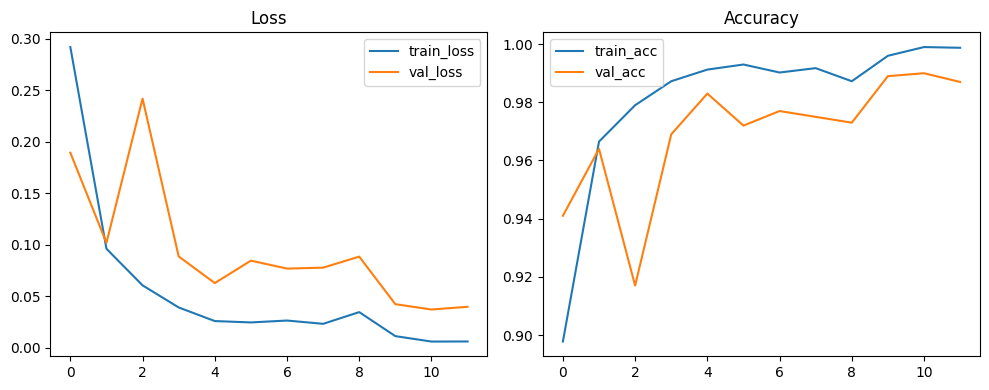

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.3, patience=3
)



def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def eval_model(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, np.array(all_preds), np.array(all_labels)

best_val_loss = float('inf')
best_model_path = "best_brisc_pytorch.pth"

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(1, EPOCHS+1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc, _, _ = eval_model(model, val_loader, criterion, DEVICE)
    scheduler.step(val_loss)

    train_losses.append(train_loss); val_losses.append(val_loss)
    train_accs.append(train_acc); val_accs.append(val_acc)

    print(f"Epoch {epoch}/{EPOCHS}  train_loss: {train_loss:.4f}  train_acc: {train_acc:.4f}  val_loss: {val_loss:.4f}  val_acc: {val_acc:.4f}")

    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss
        }, best_model_path)
        print("Saved best model ->", best_model_path)


checkpoint = torch.load(best_model_path, map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
print("Loaded best model from epoch", checkpoint['epoch'])

val_loss, val_acc, y_pred, y_true = eval_model(model, val_loader, criterion, DEVICE)
print(f"\nFinal validation loss: {val_loss:.4f}  acc: {val_acc:.4f}")

print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

cm = confusion_matrix(y_true, y_pred)
print("\nConfusion matrix:\n", cm)

final_path = "brisc2025_cnn_final.pth"
torch.save(model.state_dict(), final_path)
print("Saved final model weights ->", final_path)


plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses, label='val_loss')
plt.legend(); plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(train_accs, label='train_acc')
plt.plot(val_accs, label='val_acc')
plt.legend(); plt.title('Accuracy')

plt.tight_layout()
plt.savefig("training_plot.png")
print("Saved training_plot.png")